# Positive classification
In the final version this would need to be a second step in a pipeline, built on top of Polar/Non-polar classification.

### Loading texts into a Database

Firstly, initialise the Snorkel Session

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

Then, define the candidate subclass. The ['adjective'] means that the candidate consists of one span named adjective. As snorkel can be used for relation extraction, the examples in snorkel make a list of 2 elements (e.g. ['person1', 'person2']).  
NOTE: Making it just one element meant that  a change in LSTM training needed to be introduced  

In [2]:
from snorkel.models import candidate_subclass

Sentiment = candidate_subclass('Sentiment', ['adjective'])

Read the reviews file by file from given directory. All files are at this parsed by spacy, so any previous pre-processing is not neccessary.

In [3]:
from snorkel.parser import TextDocPreprocessor

from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

from snorkel.models import Document, Sentence

n_docs = 500
doc_preprocessor = TextDocPreprocessor('./data/reviews')



corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor, count=n_docs)

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 12.6 s, sys: 123 ms, total: 12.8 s
Wall time: 12.8 s
('Documents:', 500)
('Sentences:', 5497)


### Candidate matcher

In this task we want to match all adjectives in the text as candidates. In order to achieve that I needed to add a small class to snorkel called AdjectiveMatcher. It takes adavantage of the spacy pre-processsing performed on the inputs and matcches adjectives as candidates.  
I only thought of that a bit later, but if it was possible to combine two matchers (adjective matcher and a dictionary matcher) to improve perfomance, given the methodology of "gold annotation". However, I think that, while this might give better numerical results in this setting, it would not be good solution overall. For now, "false positives" might be considered in terms of looking for positive words not included on the list (as prepared in DataMakingSripts/sentiwords.py) - something almost like "positive words mining" (?)

In [4]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import DictionaryMatch, RegexMatchEach, AdjectiveMatcher

#Read the list of adjectives from a file - no longer used 
candlist = []
with open('./data/alllist.txt', 'r') as alist:
    for line in alist:
        word = line.strip()
        candlist.append(word)

ngrams         = Ngrams(n_max=1)
#word_matcher = DictionaryMatch(d=candlist)
#word_matcher = RegexMatchEach(rgx=r'([A-Za-z]+)/JJ')
word_matcher = AdjectiveMatcher(longest_match_only=True)
cand_extractor = CandidateExtractor(Sentiment, [ngrams], [word_matcher])

### Split the data into training, development and test

In [5]:
from snorkel.models import Document

docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
        if i % 9 == 7:
            dev_sents.add(s)
        elif i % 9 == 8:
            test_sents.add(s)
        else:
            train_sents.add(s)

In [6]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Sentiment).filter(Sentiment.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 7542)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 1154)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 899)
CPU times: user 12.2 s, sys: 147 ms, total: 12.4 s
Wall time: 12.5 s


### Preview the candidates in snorkel viewer

This is just not neccassary for the working of the classification, but helpful when developing to see if things work correctly.

In [7]:
import snorkel.viewer as sv
sv.SentenceNgramViewer(session.query(Sentiment).filter(Sentiment.split == 1)
                       , session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzMxMCwgNzA2LCA3NDhdLCBbODcsIDMxNl0sIFsyMjldXSwgW1s5MSwgMjc1XSwgWzM2OV0sIFs3MTJdXSwgW1syMDFdLCBbODE3XSwgWzc5LCDigKY=


## Defining the labelling functions (LFs)

In [8]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)
from nltk.corpus import wordnet as wn
import gensim

# Load Google's pre-trained Word2Vec model.
trained_model = gensim.models.KeyedVectors.load_word2vec_format('~/models/GoogleNews-vectors-negative300.bin', binary=True)  

In [9]:
def LF_pos_neg_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        pos = trained_model.similarity(word, 'positive')
        neg = trained_model.similarity(word, 'negative')
    except:
        return 0
    if pos > neg:
        return 1
    else:
        return -1

def LF_neg_pos_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        pos = trained_model.similarity(word, 'positive')
        neg = trained_model.similarity(word, 'negative')
    except:
        return 0
    if pos > neg:
        return 0
    else:
        return -1

def LF_good_bad_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        good = trained_model.similarity(word, 'good')
        bad = trained_model.similarity(word, 'bad')
    except:
        return 0
    if good > bad:
        return 1
    else:
        return -1

def LF_happy_sad_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        happy = trained_model.similarity(word, 'happy')
        sad = trained_model.similarity(word, 'sad')
    except:
        return 0
    if happy > sad:
        return 1
    else:
        return -1

def LF_strong_weak_sim(c):
    word = (c.adjective.get_span().encode('utf-8'))
    try:
        strong = trained_model.similarity(word, 'strong')
        weak = trained_model.similarity(word, 'weak')
    except:
        return 0
    if strong > weak:
        return 1
    else:
        return -1

#### Checking if an LF works
Test the working of a labelling function - for instance, LF_pos_neg_sim is tested here. This step is here as halper for developing LFs, can be skipped when we just want to run the full classification.

In [10]:
labeled = []
for c in session.query(Sentiment).all():
    if LF_pos_neg_sim(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 9310)


In [11]:
#import snorkel.viewer as sv
#sv.SentenceNgramViewer(labeled, session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzIxNCwgNzE2MSwgNzI3OF0sIFszNTc1LCA0MTM3LCA0ODg0XSwgWzM2NDJdXSwgW1sxOTg4XSwgWzU5MzBdLCBbNjExMV1dLCBbWzU1MV0sIFvigKY=


#### Insert the labelling functions that you want to use into a list.

In [12]:
LFs = [
    LF_pos_neg_sim,  LF_good_bad_sim, LF_happy_sad_sim 
]

### Load the gold labels from external file

Uses util.py file located in the same directory. Within the util.py file the path to the file with gold annotations is provided.  
NOTE: Label loading code in snorkel is nondestructive, so re-running this cell within the same session won't replace existing labels in the database.

In [13]:
from util import load_external_labels

%time missed = load_external_labels(session, Sentiment, annotator_name='gold')

AnnotatorLabels created: 678
AnnotatorLabels created: 572
CPU times: user 1min 9s, sys: 129 ms, total: 1min 9s
Wall time: 1min 9s


In [14]:
from snorkel.annotations import load_gold_labels


L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [15]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [16]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 28.2 s, sys: 55.6 ms, total: 28.3 s
Wall time: 28.3 s


<7542x3 sparse matrix of type '<type 'numpy.int64'>'
	with 21912 stored elements in Compressed Sparse Row format>

In [17]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 183 ms


<7542x3 sparse matrix of type '<type 'numpy.int64'>'
	with 21912 stored elements in Compressed Sparse Row format>

In [18]:
L_train.get_candidate(session, 0)

Sentiment(Span("great", sentence=3800, chars=[25,29], words=[6,6]))

In [19]:
L_train.get_key(session, 0)

LabelKey (LF_pos_neg_sim)


* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [20]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_pos_neg_sim,0,0.968443,0.968443,0.369928
LF_good_bad_sim,1,0.968443,0.968443,0.369928
LF_happy_sad_sim,2,0.968443,0.968443,0.369928


## Fitting the Generative Model

In [21]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


#### Insight into the model
Can be skipped if just looking for the final results.

In [22]:
gen_model.weights.lf_accuracy

array([ 1.25001361,  1.52670394,  1.0150343 ])

In [23]:
train_marginals = gen_model.marginals(L_train)

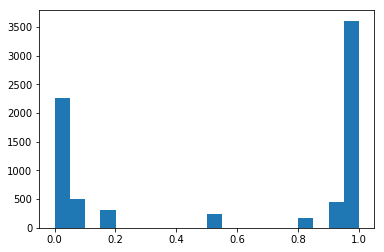

In [24]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [25]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.929188,0.7880,0.923077,0.725605
1,0.956115,0.8226,0.954522,0.778982
2,0.880609,0.7622,0.873290,0.665346


## Debugging Labelling Functions

Load L_gold_dev for the dev set.

In [26]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



Scores for the dev set.

In [27]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.767
Neg. class accuracy: 0.53
Precision            0.395
Recall               0.767
F1                   0.522
----------------------------------------
TP: 253 | FP: 387 | TN: 437 | FN: 77



In [39]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    #alter the 'fp' below to any category you want for insight (tp, fp, tn, fn)
    sv = SentenceNgramViewer(fp, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [29]:
sv

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzI0Ml0sIFs2OF0sIFsyODBdXSwgW1syOTZdLCBbMTU0XSwgWzM1NSwgMzc2LCAzNzksIDM4MSwgMzgzXV0sIFtbMjc0XSwgWzI1LCAzNjZdLCDigKY=


In [30]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_pos_neg_sim,0,0.980936,0.980936,0.363085,258,163,72,185,0.653392,0.923476
LF_good_bad_sim,1,0.980936,0.980936,0.363085,258,178,72,170,0.631268,0.955671
LF_happy_sad_sim,2,0.980936,0.980936,0.363085,223,149,107,199,0.622419,0.887485


In [31]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 7542 marginals
CPU times: user 4.64 s, sys: 7.73 ms, total: 4.65 s
Wall time: 4.68 s


In [32]:
from snorkel.annotations import load_marginals

train_marginals = load_marginals(session, split=0)

In [33]:
train_cands = session.query(Sentiment).filter(Sentiment.split == 0).order_by(Sentiment.id).all()
dev_cands   = session.query(Sentiment).filter(Sentiment.split == 1).order_by(Sentiment.id).all()
test_cands  = session.query(Sentiment).filter(Sentiment.split == 2).order_by(Sentiment.id).all()

In [34]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [35]:
from snorkel.learning.pytorch.rnn import LSTM

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   50,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm = LSTM(n_threads=1)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)



[LSTM] Training model
[LSTM] n_train=7304  #epochs=50  batch size=128
[LSTM] Epoch 1 (9.78s)	Average loss=0.682027	Dev F1=44.47
[LSTM] Epoch 2 (20.58s)	Average loss=0.678772	Dev F1=44.08
[LSTM] Epoch 3 (30.88s)	Average loss=0.667167	Dev F1=42.48
[LSTM] Epoch 4 (41.46s)	Average loss=0.635194	Dev F1=43.62
[LSTM] Epoch 5 (51.56s)	Average loss=0.592130	Dev F1=44.91
[LSTM] Epoch 6 (63.05s)	Average loss=0.529338	Dev F1=44.47
[LSTM] Epoch 7 (73.50s)	Average loss=0.442532	Dev F1=46.30
[LSTM] Epoch 8 (83.81s)	Average loss=0.391602	Dev F1=46.30
[LSTM] Epoch 9 (94.01s)	Average loss=0.426924	Dev F1=46.59
[LSTM] Epoch 10 (104.44s)	Average loss=0.324646	Dev F1=47.70
[LSTM] Epoch 11 (114.49s)	Average loss=0.299606	Dev F1=47.46
[LSTM] Epoch 12 (124.86s)	Average loss=0.272475	Dev F1=47.88
[LSTM] Epoch 13 (135.17s)	Average loss=0.394183	Dev F1=35.56
[LSTM] Epoch 14 (146.16s)	Average loss=0.575455	Dev F1=45.47
[LSTM] Epoch 15 (156.23s)	Average loss=0.386106	Dev F1=48.05
[LSTM] Epoch 16 (166.22s)	Average 

## Results
Same as in polar/non-polar classification, this might suffer as the gold set is not of high quality.

In [36]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.410, Recall: 0.764, F1 Score: 0.533


In [37]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.764
Neg. class accuracy: 0.457
Precision            0.41
Recall               0.764
F1                   0.533
----------------------------------------
TP: 227 | FP: 327 | TN: 275 | FN: 70



In [38]:
lstm.save_marginals(session, test_cands)

Saved 899 marginals
